In [1]:
import pandas as pd
import numpy as np
import random

In [2]:
from itertools import product
import gensim
import pickle

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage

## Second Patient Set (Males)

In [4]:
#load patient vectors from HMP-T2D
vec_p1 = pickle.load(open("m_vec_p1.p", "rb"))
vec_p2 = pickle.load(open("m_vec_p2.p", "rb"))
vec_p3 = pickle.load(open("m_vec_p3.p", "rb"))
vec_p4 = pickle.load(open("m_vec_p4.p", "rb"))

In [6]:
#a vector (length 10) for each sequence that is an average of all 6 'versions' of that sequence
#should be equal to number of original reads per patient
print('Vectors in P1:', len(vec_p1))
print('Vectors in P2:', len(vec_p2))
print('Vectors in P3:', len(vec_p3))
print('Vectors in P4:', len(vec_p4))

Vectors in P1: 25000
Vectors in P2: 25000
Vectors in P3: 25000
Vectors in P4: 25000


In [5]:
#This dataset was much larger than the others, 
#randomly sampled 25,000 from each in order to facilitate completion
np.random.seed(42)
ind_p1 = np.random.choice(range(89870), 25000).tolist()
ind_p2 = np.random.choice(range(66346), 25000).tolist()
ind_p3 = np.random.choice(range(52972), 25000).tolist()
ind_p4 = np.random.choice(range(53018), 25000).tolist()

vec_p1 = [vec_p1[i] for i in ind_p1]
vec_p2 = [vec_p2[i] for i in ind_p2]
vec_p3 = [vec_p3[i] for i in ind_p3]
vec_p4 = [vec_p4[i] for i in ind_p4]

## PCA

In [8]:
X = np.concatenate((vec_p1, vec_p2, vec_p3, vec_p4))
y = np.concatenate((np.ones(25000), np.full(25000, 2), np.full(25000, 3), np.full(25000, 4)))

In [9]:
# Take all of the data and plot it on 2 dimensions
pca = PCA(n_components=2)
pca.fit(X)
pcafeatures_train = pca.transform(X)

In [10]:
# Create a plot of the PCA results
from itertools import cycle

def plot_PCA_2D(data, target, target_names):
    colors = cycle(['r','g','b','c','m','y','orange','w','aqua','yellow'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(10,10))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label, edgecolors='gray')
    plt.legend()

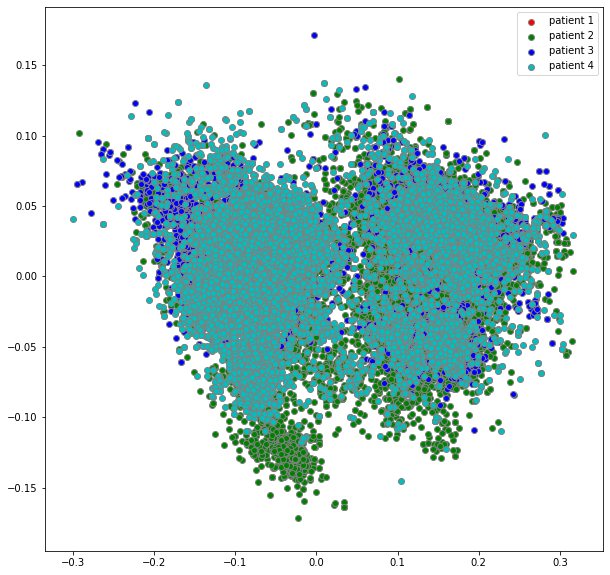

In [11]:
# plot PC1 vs PC2 of all the sequences
plot_PCA_2D(pcafeatures_train, target=y, target_names=['patient 1', 'patient 2', 'patient 3', 'patient 4'])

## Clustering

### Heirarchical

[(0, 8037), (1, 6233), (2, 3503), (3, 4034), (4, 3193)]
[(0, 2346), (1, 2077), (2, 5607), (3, 10518), (4, 4452)]
[(0, 6370), (1, 3116), (2, 10466), (3, 3103), (4, 1945)]
[(0, 6047), (1, 2258), (2, 6191), (3, 7480), (4, 3024)]


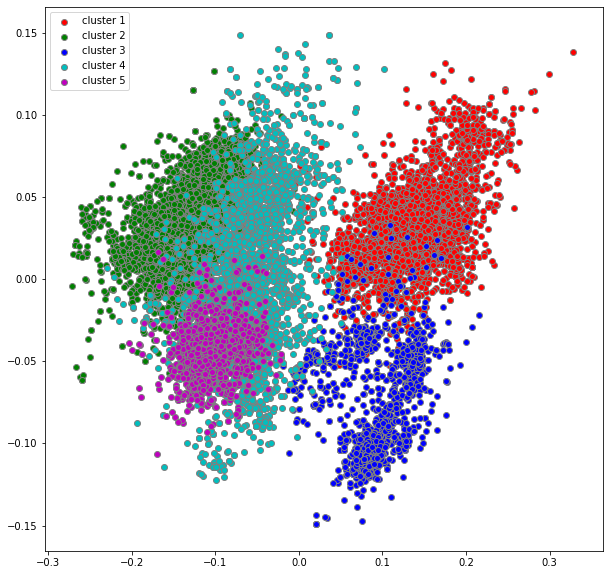

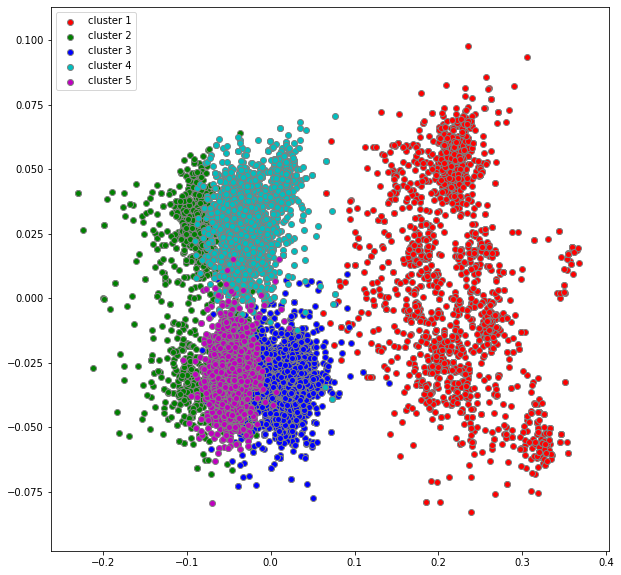

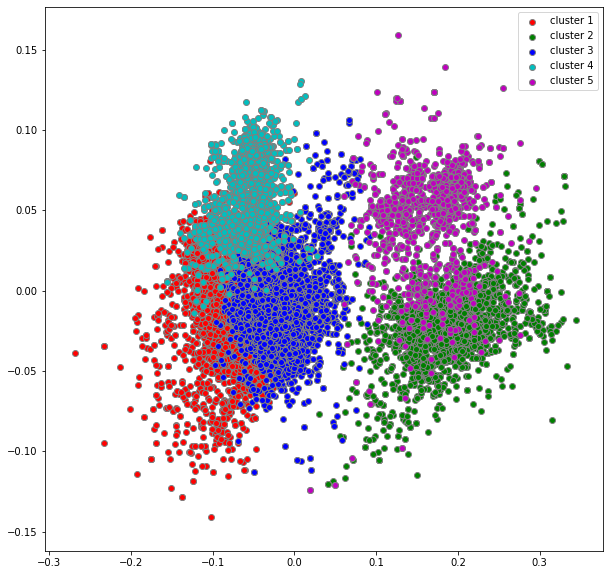

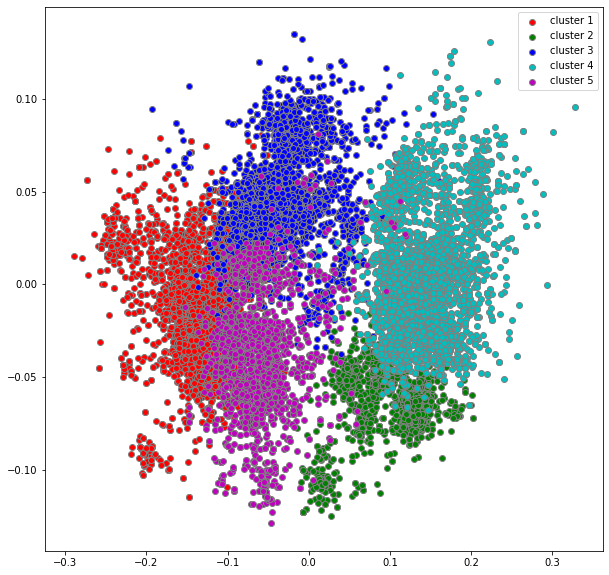

In [12]:
#get cluster labels and determine number of points within each cluster

hc_labels = []
children = []

for ind,patient in enumerate([vec_p1, vec_p2, vec_p3, vec_p4]):
    hc = AgglomerativeClustering(linkage='ward', n_clusters=5)
    hc.fit(patient)
    labels = hc.labels_
    y = np.bincount(labels)
    ii = np.nonzero(y)[0]
    print(list(zip(ii,y[ii])))
    hc_labels.append(labels)
    children.append(hc.children_)
    
    #plot using pc1/pc2
    pca = PCA(n_components=2)
    pca.fit(patient)
    pcafeatures_train = pca.transform(patient)

    plot_PCA_2D(pcafeatures_train, target=hc_labels[ind], 
            target_names=['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5'])

In [13]:
def find_nearest(vectors, center):
    current_min = (0, 1)
    for i, vector in enumerate(vectors):
        new_min = (i, sum(np.abs(np.subtract(np.asarray(vector), np.asarray(center)))))
        if new_min[1] < current_min[1]:
            current_min = new_min
    return current_min

In [14]:
#find "centers" of agglomerative clustering
#actually it's the average of all points of that cluster in the 10-dim space
#find_nearest returns the vector that is "nearest" to the determined "center"
def find_center(labels, num_clusters, vectors):
    hc_centers = []
    actual_centers = []
    for clust in range(num_clusters):
        clust_ind = [i for i, x in enumerate(labels) if x == clust]
        vec_ind = [vectors[i] for i in clust_ind]
        hc_centers.append(sum(vec_ind)/len(clust_ind))
    
    for center in hc_centers:
        actual_centers.append(find_nearest(vectors, center))
    return actual_centers

In [15]:
#this returns the index and distance from the calculated 'center' of the representative sequences for each cluster
#these can be plugged back into the original data in order to BLAST the representative sequences to interpret species 
for ind, patient in enumerate([vec_p1, vec_p2, vec_p3, vec_p4]):
    cents = find_center(hc_labels[ind], 5, patient)
    print('Centers for Patient', ind+1)
    print(cents)

Centers for Patient 1
[(23945, 0.046360988169908524), (20240, 0.040233008563518524), (3624, 0.03146921098232269), (22505, 0.07583348825573921), (545, 0.03488617390394211)]
Centers for Patient 2
[(11319, 0.08610643818974495), (13516, 0.07444263435900211), (6292, 0.01899230107665062), (1880, 0.016429100185632706), (13211, 0.024544022977352142)]
Centers for Patient 3
[(17170, 0.04341352358460426), (14556, 0.05647028610110283), (14321, 0.01951194554567337), (11145, 0.037040673196315765), (858, 0.04171057790517807)]
Centers for Patient 4
[(7131, 0.0902378149330616), (11366, 0.07148067653179169), (8346, 0.08169310167431831), (24556, 0.03939385712146759), (6155, 0.0761156715452671)]
